# TODO: update with optimized model hyperparameters

this notebook will have clean functions that can be run on all course datasets
- run final models show the optimized output metrics (for NN, also plots accuracy over epochs and NN architecture)
- learning curves
- check them for underfit/overfit by plotting training error vs test error
- calculate precision/recall/accuracy/f1 scores for each
- plot AUC, ROC
- plot of model training time vs f1? idk just a query

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset

In [107]:
dataPath = "../Data/students_mental_health_survey.csv"
df = pd.read_csv(dataPath)

In [108]:
""" Dataset Description """
dataset_shape = df.shape
dataset_info = df.info
missing_vals = df.isnull().sum()
print(f"{"="*15}Dataset Shape{"="*15}\n{dataset_shape}\n\n{"="*15}Data Types and Column Info{"="*15}\n{dataset_info}\n{"="*15}Missing Values{"="*15}\n{missing_vals}\n\n{"="*15}Unique Values by Column{"="*15}\n")

# unique values for each column:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}:{unique_values}")

===============Dataset Shape===============
(7022, 20)

===============Data Types and Column Info===============
<bound method DataFrame.info of       Age            Course  ... Semester_Credit_Load  Residence_Type
0      25            Others  ...                   17       On-Campus
1      24       Engineering  ...                   27       On-Campus
2      19          Business  ...                   15       On-Campus
3      19  Computer Science  ...                   20      Off-Campus
4      18          Business  ...                   23       On-Campus
...   ...               ...  ...                  ...             ...
7017   20               Law  ...                   26      Off-Campus
7018   24           Medical  ...                   15      Off-Campus
7019   26            Others  ...                   17      Off-Campus
7020   24           Medical  ...                   18      Off-Campus
7021   22           Medical  ...                   17     With Family

[7022 rows x 2

# Preprocessing

In [109]:
""" Handling missing values """
numeric_imputer = SimpleImputer(strategy='mean')
df[['CGPA']] = numeric_imputer.fit_transform(df[['CGPA']])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[['Substance_Use']] = categorical_imputer.fit_transform(df[['Substance_Use']])

missing_vals = df.isnull().sum()
print(f"{"="*15}Missing Values{"="*15}\n{missing_vals}")

===============Missing Values===============
Age                            0
Course                         0
Gender                         0
CGPA                           0
Stress_Level                   0
Depression_Score               0
Anxiety_Score                  0
Sleep_Quality                  0
Physical_Activity              0
Diet_Quality                   0
Social_Support                 0
Relationship_Status            0
Substance_Use                  0
Counseling_Service_Use         0
Family_History                 0
Chronic_Illness                0
Financial_Stress               0
Extracurricular_Involvement    0
Semester_Credit_Load           0
Residence_Type                 0
dtype: int64


In [110]:
""" Label Encoding """
DEPRESSION_THRESHOLD = 3
df['Depression_Score'] = df['Depression_Score'].apply(lambda x: 1 if x > DEPRESSION_THRESHOLD else 0)

mod_low_high_cols = ['Physical_Activity', 'Social_Support', 'Extracurricular_Involvement']
mod_low_high_map = {'Low': 0, 'Moderate': 0.5, 'High': 1}
for column in mod_low_high_cols:
    df[column] = df[column].map(mod_low_high_map)

yes_no_cols = ['Family_History', 'Chronic_Illness']
yes_no_map = {'Yes': 1, 'No': 0}
for column in yes_no_cols:
    df[column] = df[column].map(yes_no_map)

freq_cols = ['Substance_Use', 'Counseling_Service_Use']
freq_map = {'Never': 0, 'Occasionally': 0.5, None:None, 'Frequently': 1}
for column in freq_cols:
    df[column] = df[column].map(freq_map)

good_poor_avg_cols = ['Sleep_Quality','Diet_Quality']
good_poor_avg_map = {'Good': 1, 'Poor': 0,'Average':0.5}
for column in good_poor_avg_cols:
    df[column] = df[column].map(good_poor_avg_map)

gender_map = {'Male': 1, 'Female': 0}
df['Gender'] = df['Gender'].map(gender_map)

relationship_map = {'Married': 1, 'Single': 0, 'In a Relationship':0.5}
df['Relationship_Status'] = df['Relationship_Status'].map(relationship_map)

residence_map = {'On-Campus': 0, 'Off-Campus': 0.5, 'With Family': 1}
df['Residence_Type'] = df['Residence_Type'].map(residence_map)

print(f"Unique Values by Column{"="*15}\n")

# unique values for each column:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}:{unique_values}")

Unique Values by Column===============

Age:[25 24 19 18 21 23 28 22 27 20 31 26 35 30 32 29 34 33]
Course:['Others' 'Engineering' 'Business' 'Computer Science' 'Medical' 'Law']
Gender:[1 0]
CGPA:[3.56       2.44       3.74       3.65       3.4        3.35
 3.8        3.05       3.49126961 3.19       3.26       3.2
 3.61       3.85       3.46       3.43       3.38       3.5
 3.6        3.08       3.88       3.21       3.62       3.16
 3.71       3.48       3.27       3.41       3.22       3.33
 3.01       3.97       4.         3.63       2.99       3.11
 3.02       3.66       3.09       3.12       3.82       3.23
 3.7        2.95       3.73       3.64       3.79       3.59
 3.34       3.87       3.24       3.44       3.1        3.25
 3.53       3.         3.29       2.98       3.04       3.51
 3.75       3.86       3.78       3.77       3.72       3.45
 3.06       3.84       3.92       3.28       2.86       3.37
 3.54       3.31       3.94       3.9        3.52       3.32
 3.14       3

# EDA

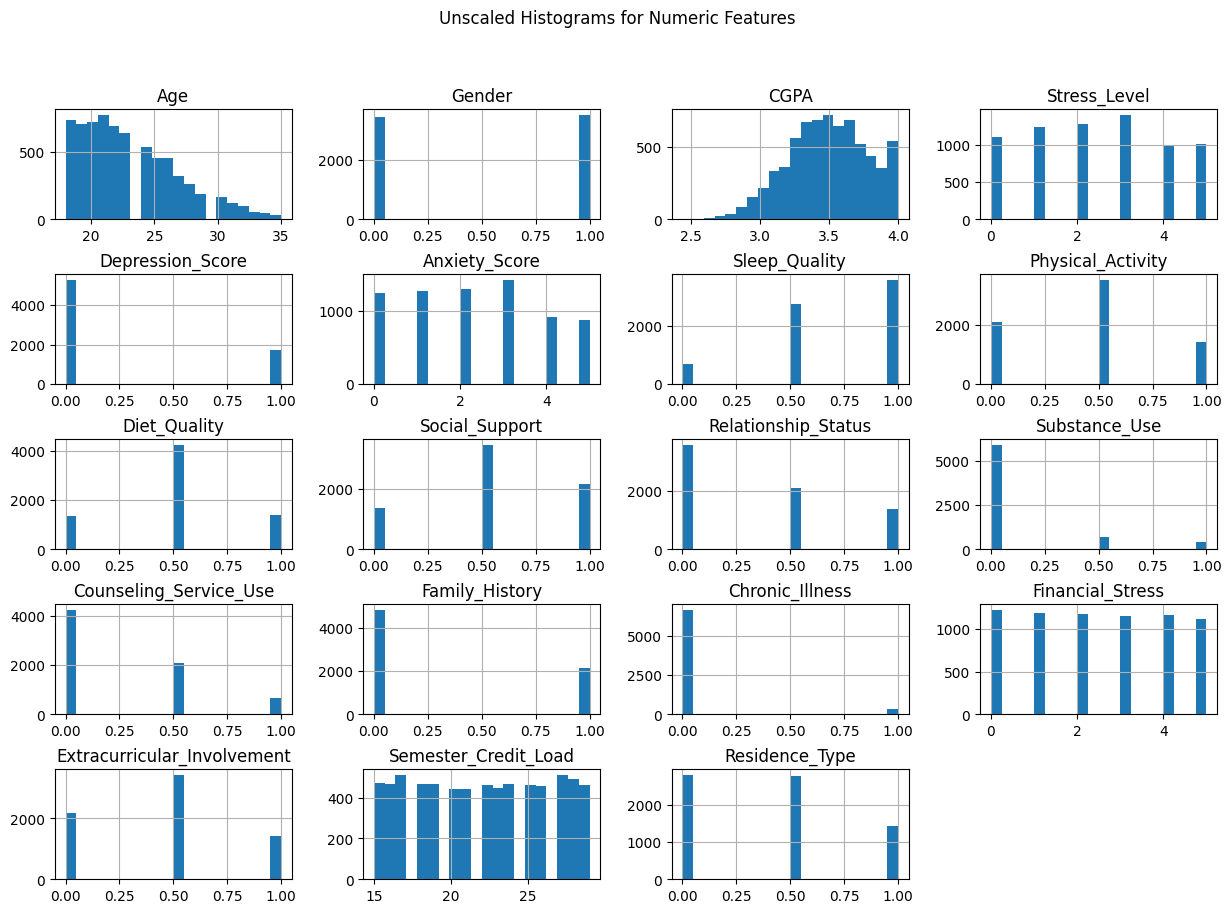

In [80]:
all_numeric_cols =['Age', 'Gender', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Sleep_Quality', 'Physical_Activity', 'Diet_Quality', 'Social_Support', 'Relationship_Status', 'Substance_Use', 'Counseling_Service_Use', 'Family_History', 'Chronic_Illness', 'Financial_Stress', 'Extracurricular_Involvement', 'Semester_Credit_Load', 'Residence_Type']

df[all_numeric_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Unscaled Histograms for Numeric Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Scaling

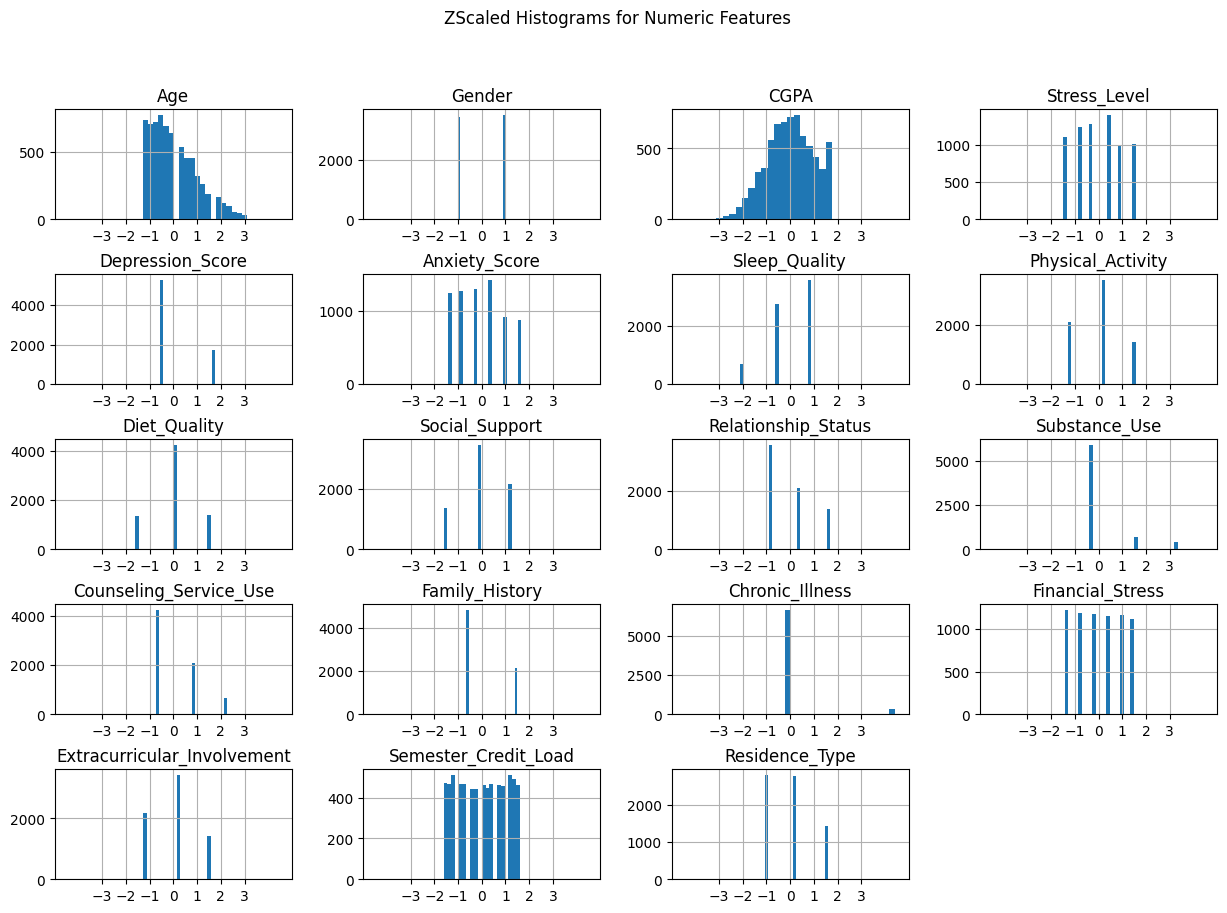

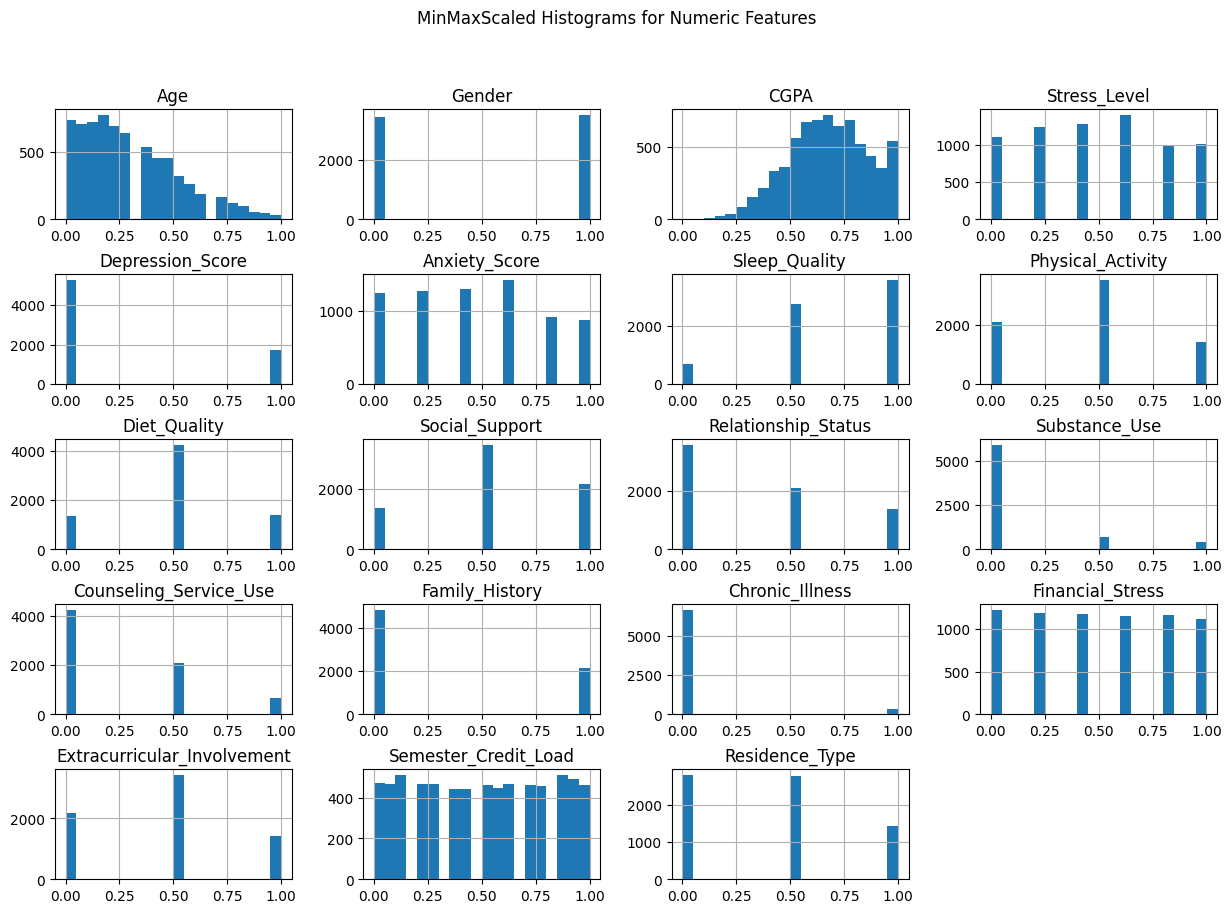

In [81]:
""" Scaling: Z-scale and MinMax"""
Zscaler = StandardScaler()
df_Zscaled = df.copy()
df_Zscaled[all_numeric_cols] = Zscaler.fit_transform(df[all_numeric_cols])
# plotting
axes = df_Zscaled.hist(bins=20, figsize=(15, 10))
for ax in axes.flatten():
    ax.set_xlim([-5, 5])
    ax.set_xticks(np.arange(-3, 4, 1))
plt.suptitle('ZScaled Histograms for Numeric Features')
plt.subplots_adjust(hspace=0.5)
plt.show()


cols_not_minmax_scaled =['Age',  'CGPA', 'Stress_Level', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']
minMaxScaler = MinMaxScaler()
df_MinMaxScaled= df.copy()
df_MinMaxScaled[cols_not_minmax_scaled] = minMaxScaler.fit_transform(df[cols_not_minmax_scaled])
# plotting
df_MinMaxScaled.hist(bins=20, figsize=(15, 10))
plt.suptitle('MinMaxScaled Histograms for Numeric Features')
plt.subplots_adjust(hspace=0.5)
plt.show()

## Box Plots

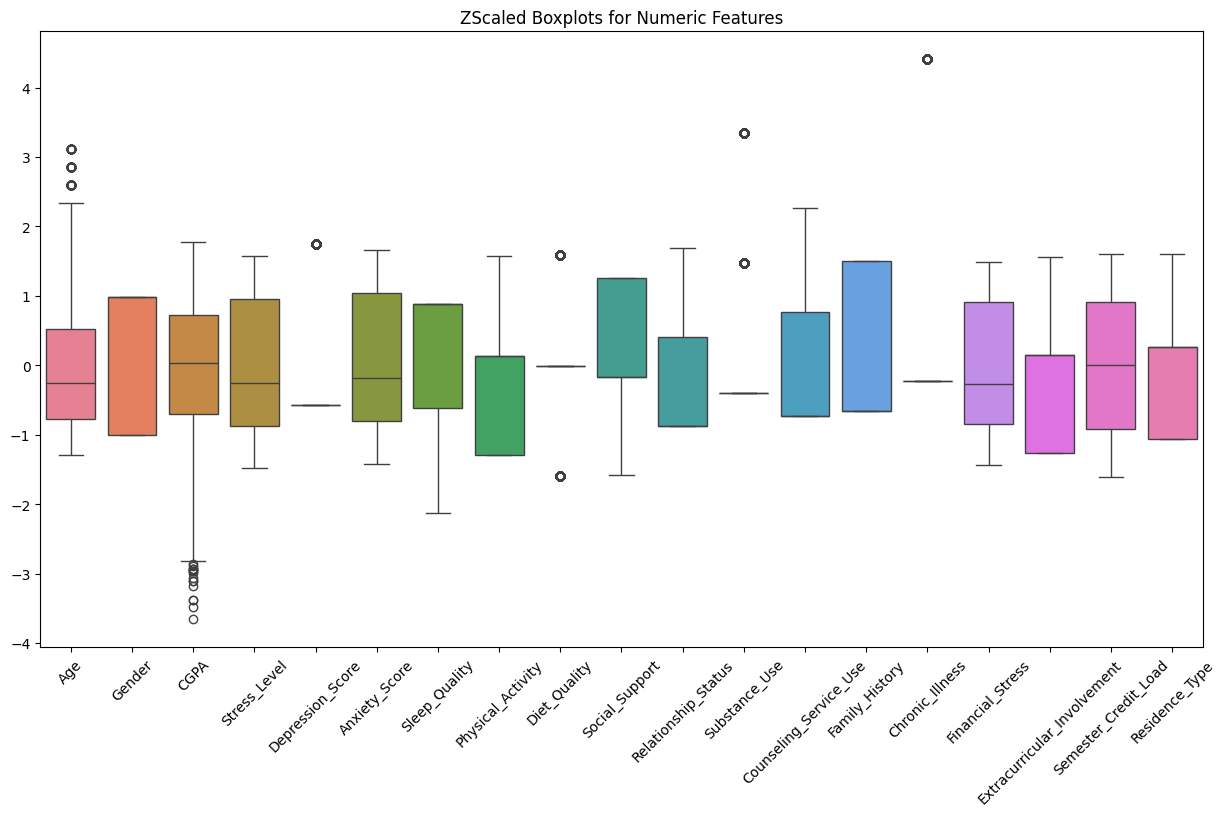

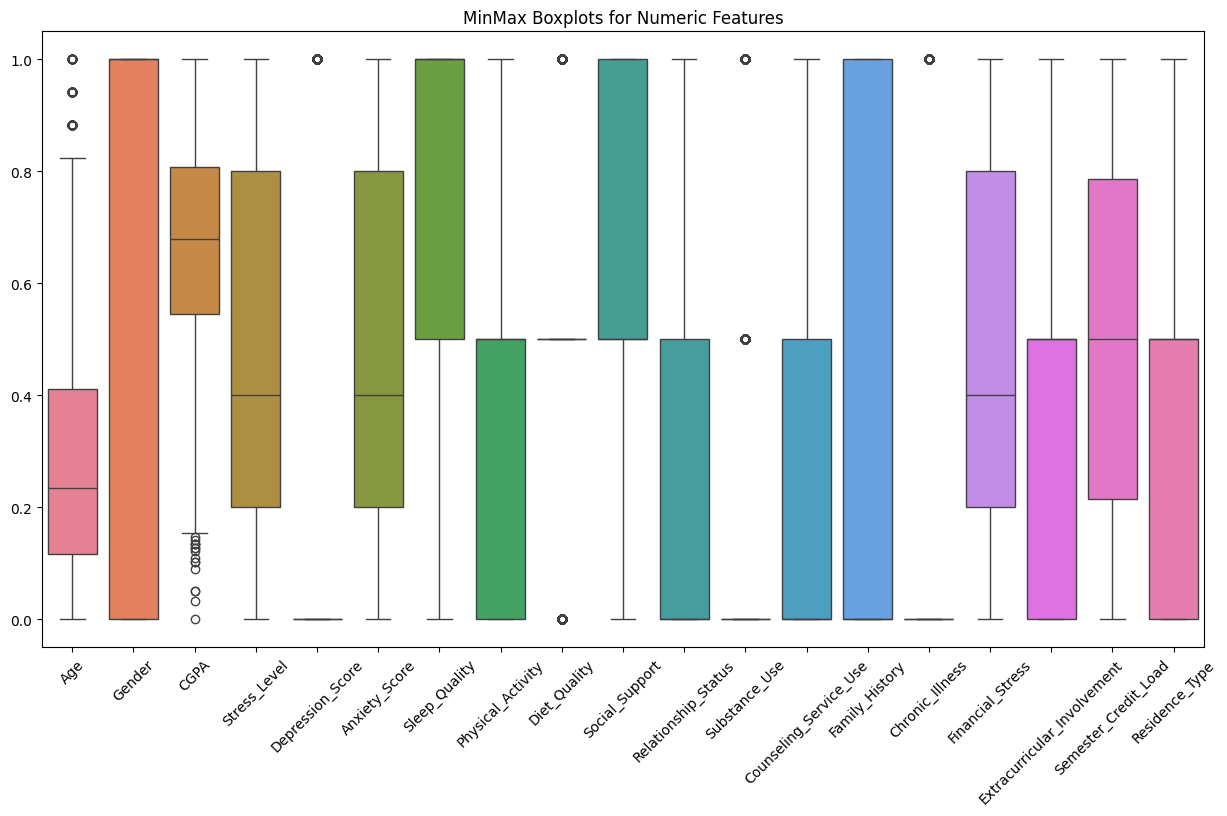

In [82]:
# Z_Scaled
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_Zscaled[all_numeric_cols])
plt.title('ZScaled Boxplots for Numeric Features')
plt.xticks(rotation=45)
plt.show()

# MinMax
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_MinMaxScaled[all_numeric_cols])
plt.title('MinMax Boxplots for Numeric Features')
plt.xticks(rotation=45)
plt.show()

## Correlation Matrices

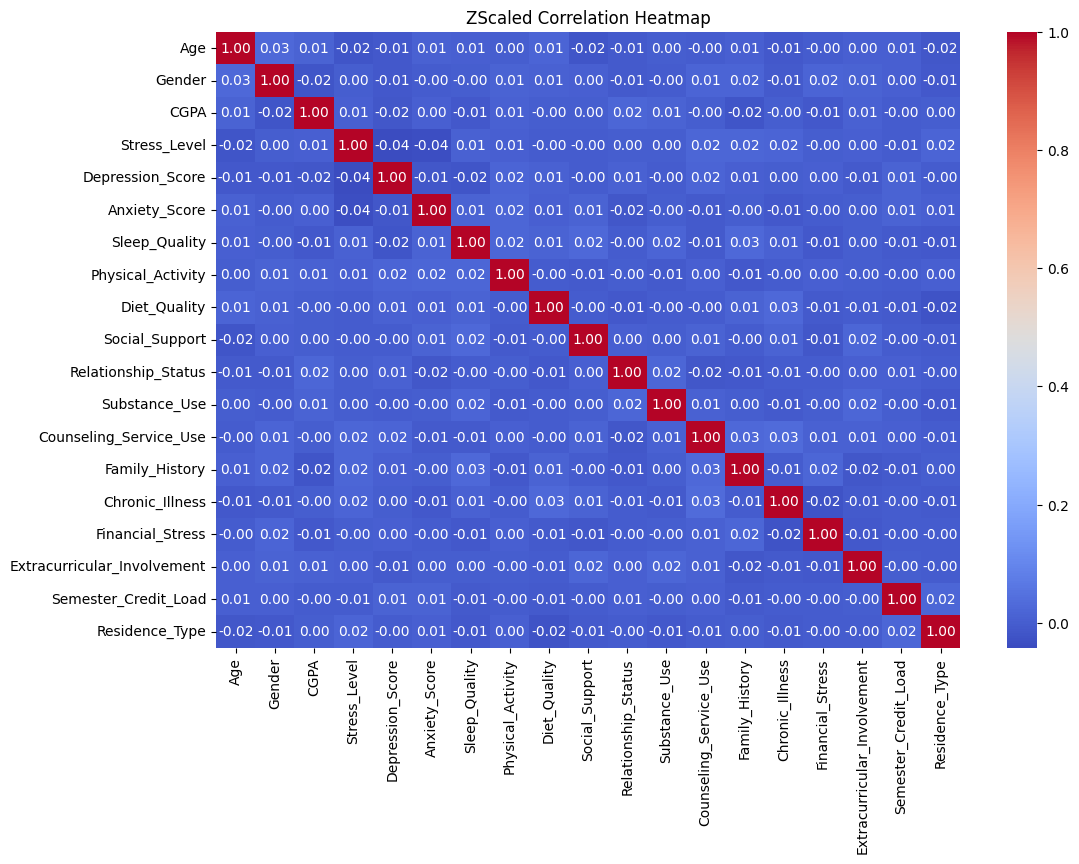

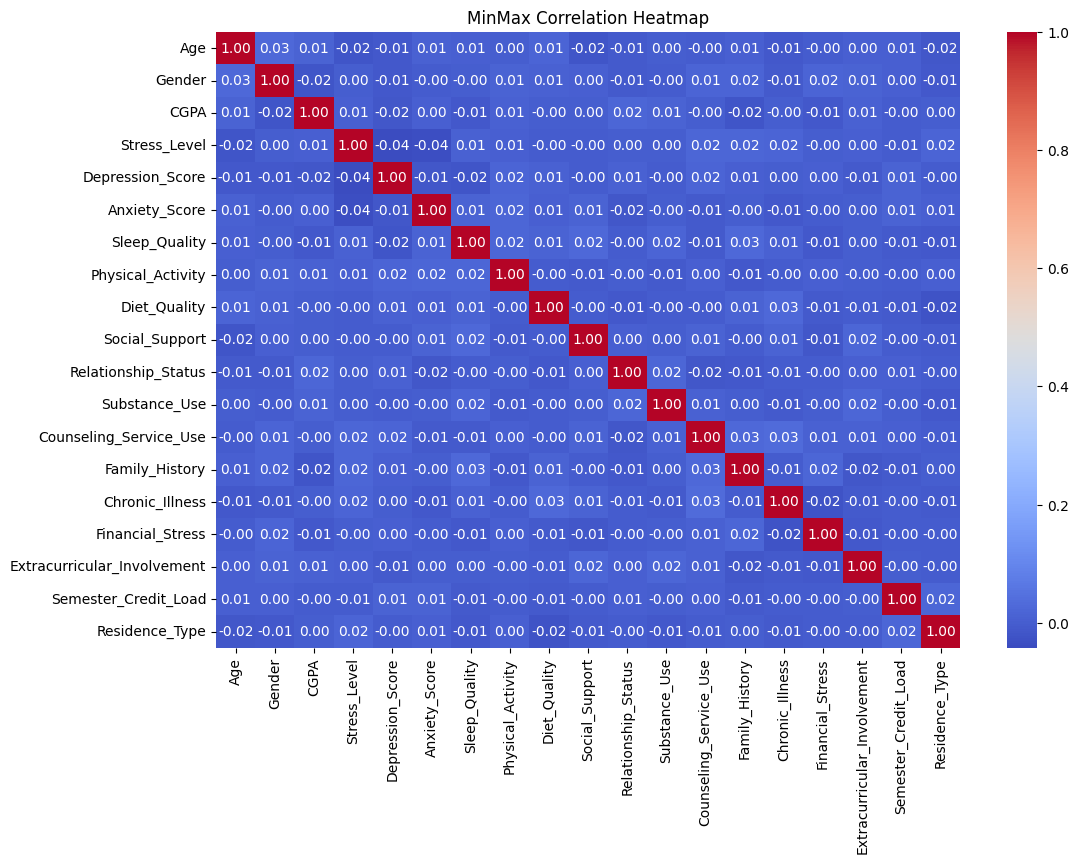

In [83]:
# Z_Scaled
plt.figure(figsize=(12, 8))
correlation_matrix = df_Zscaled[all_numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('ZScaled Correlation Heatmap')
plt.show()

# MinMax
plt.figure(figsize=(12, 8))
correlation_matrix = df_MinMaxScaled[all_numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('MinMax Correlation Heatmap')
plt.show()

## Outlier Detection

In [84]:
def calculate_outliers(df, column_name, remove=False):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    
    if(remove):
        return len(outliers), df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return len(outliers), df

In [85]:
num_age_outliers, _ = calculate_outliers(df_Zscaled, 'Age', False)
print("Number of Age outliers:", num_age_outliers)
num_cgpa_outliers, _ = calculate_outliers(df_Zscaled, 'CGPA', False)
print("Number of CGPA outliers:", num_cgpa_outliers)

Number of Age outliers: 131
Number of CGPA outliers: 16


# Export and save cleaned data

In [86]:
for course in df['Course'].unique():
    df[df['Course'] == course].to_csv(f'../Data/final/clean_df_{course}.csv', index=False)

# Feature Selection

## tSNE

In [87]:
raw_df = pd.read_csv("../Data/clean_df_main.csv")

course_map = {
    'business': 0,
    'engineering': 1,
    'law': 2,
    'medical': 3,
    'others': 4,
    'compsci': 5
}
raw_df['Course'] = raw_df['Course'].map(course_map)
df = raw_df.drop(['Course'], axis=1)

In [88]:
X = df.drop(['Depression_Score'], axis=1)
y = df['Depression_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=13, test_size=0.25, shuffle=True
)

Scenario 1 - Number of components for 95% variance explained: 18


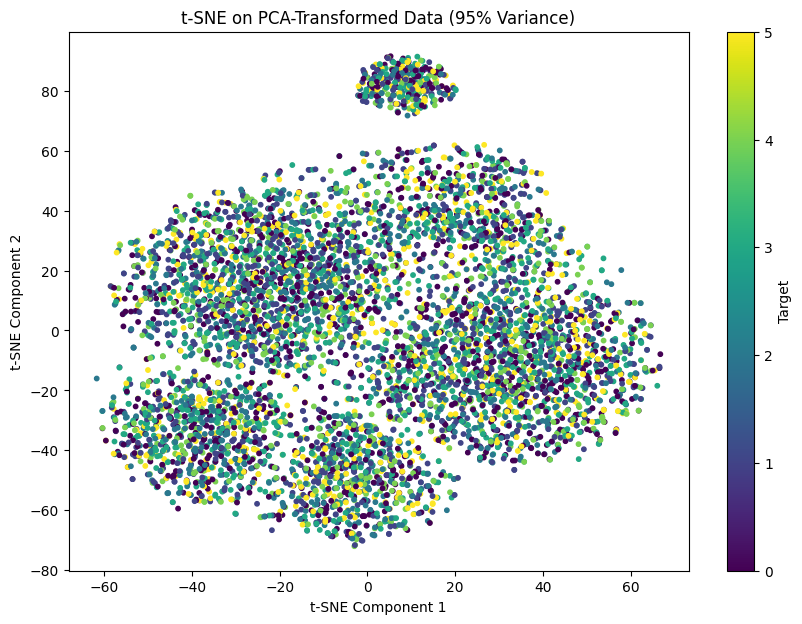

Scenario 2 - PCA with 5 components:
        PC1       PC2       PC3       PC4       PC5
0  0.178877 -0.020894 -1.581074  1.155073  1.198459
1  0.401841 -1.148668  1.433366  0.072223  1.582879
2  0.078813  1.507753 -0.378902  0.825023 -0.016466
3  0.745699  2.988602 -2.418671 -1.132326  0.189275
4  0.380287 -0.382985 -0.765506 -1.033182 -0.259586


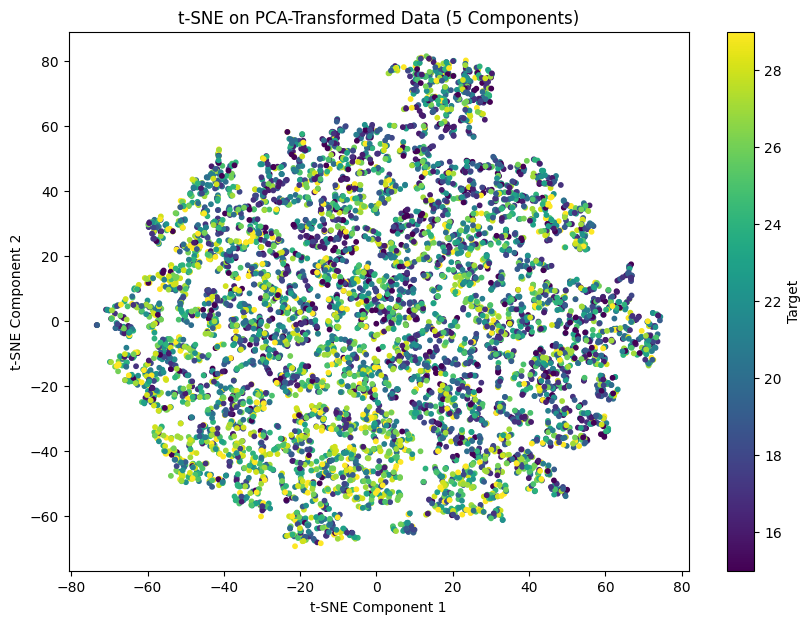

In [89]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# Normalize the data
X_scaled = Zscaler.fit_transform(X)

# Scenario 1: PCA with 95% Variance Explained
pca_95 = PCA(n_components=0.95)
X_pca_95 = pca_95.fit_transform(X_scaled)

# Check the number of components selected
print(f"Scenario 1 - Number of components for 95% variance explained: {pca_95.n_components_}")

# Run t-SNE on PCA-transformed data (Scenario 1)
tsne_95 = TSNE(n_components=2, random_state=42)
X_tsne_95 = tsne_95.fit_transform(X_pca_95)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne_95[:, 0], X_tsne_95[:, 1], c=y, cmap='viridis', s=10)
plt.colorbar(label='Target')
plt.title('t-SNE on PCA-Transformed Data (95% Variance)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Scenario 2: PCA with a Fixed Number of Components (e.g., 5)
pca_fixed = PCA(n_components=5)
X_pca_fixed = pca_fixed.fit_transform(X_scaled)

print("Scenario 2 - PCA with 5 components:")
pca_fixed_df = pd.DataFrame(X_pca_fixed, columns=[f"PC{i+1}" for i in range(5)])
print(pca_fixed_df.head())

# Run t-SNE on PCA-transformed data (Scenario 2)
tsne_fixed = TSNE(n_components=2, random_state=42)
X_tsne_fixed = tsne_fixed.fit_transform(X_pca_fixed)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne_fixed[:, 0], X_tsne_fixed[:, 1], c=X['Semester_Credit_Load'], cmap='viridis', s=10)
plt.colorbar(label='Target')
plt.title('t-SNE on PCA-Transformed Data (5 Components)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Feature Importance

In [90]:
courses = ['business', 'compsci', 'engineering','law','medical','others']

In [103]:
def get_best_rf_params(X_train, X_test, y_train, y_test, verbose=False):
    best_accuracy_rf = 0
    n_for_best_accuracy_rf = 0
    max_feat_for_best_accuracy_rf = 0

    for n in range(10, 100, 5):
        for max_feat in [1, 'log2', 'sqrt']:
            # Create a Random Forest model
            random_forest = RandomForestClassifier(max_features=max_feat, n_estimators=n, random_state=42)
            random_forest.fit(X_train, y_train)

            # Predict and evaluate
            y_pred_rf = random_forest.predict(X_test)
            accuracy_rf = accuracy_score(y_test, y_pred_rf)
            if verbose:
                print(f'Random Forest [n_estimators={n}, max_features={max_feat}] Accuracy: {accuracy_rf:.4f}')

            if accuracy_rf > best_accuracy_rf and accuracy_rf < 1.0:
                best_accuracy_rf = accuracy_rf
                n_for_best_accuracy_rf = n
                max_feat_for_best_accuracy_rf = max_feat
            
    return n_for_best_accuracy_rf, max_feat_for_best_accuracy_rf

def get_importance(X_train, X_test, y_train, y_test, importance_threshold=0.08, importance_verbose=False, params_verbose=False):
    n, max_feat = get_best_rf_params(X_train, X_test, y_train, y_test, params_verbose)
    random_forest = RandomForestClassifier(max_features=max_feat, n_estimators=n, random_state=42)
    random_forest.fit(X_train, y_train)

    y_pred_rf = random_forest.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)

    rf_feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': random_forest.feature_importances_})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    if importance_verbose:
        print()
        print("Accuracy:", accuracy_rf, '\n')
        print("Feature Importance:")
        print(rf_feature_importances_df)

    features = X.columns
    n_features = len(features)

    plt.figure(figsize=(15, 8))
    plt.bar(features, random_forest.feature_importances_)
    plt.plot(features, importance_threshold*np.ones(n_features), 'r--')
    plt.xticks(features, rotation=45)
    plt.title("Importance using Random Forest")
    plt.show()

=============== business ===============

Accuracy: 0.2837209302325581 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.101563
0                           Age    0.095268
16         Semester_Credit_Load    0.091095
4                 Anxiety_Score    0.077144
3                  Stress_Level    0.073354
14             Financial_Stress    0.070987
15  Extracurricular_Involvement    0.053583
6             Physical_Activity    0.051674
7                  Diet_Quality    0.051021
5                 Sleep_Quality    0.050678
17               Residence_Type    0.049740
9           Relationship_Status    0.048464
8                Social_Support    0.046111
11       Counseling_Service_Use    0.040965
10                Substance_Use    0.030862
12               Family_History    0.029003
1                        Gender    0.028766
13              Chronic_Illness    0.009723


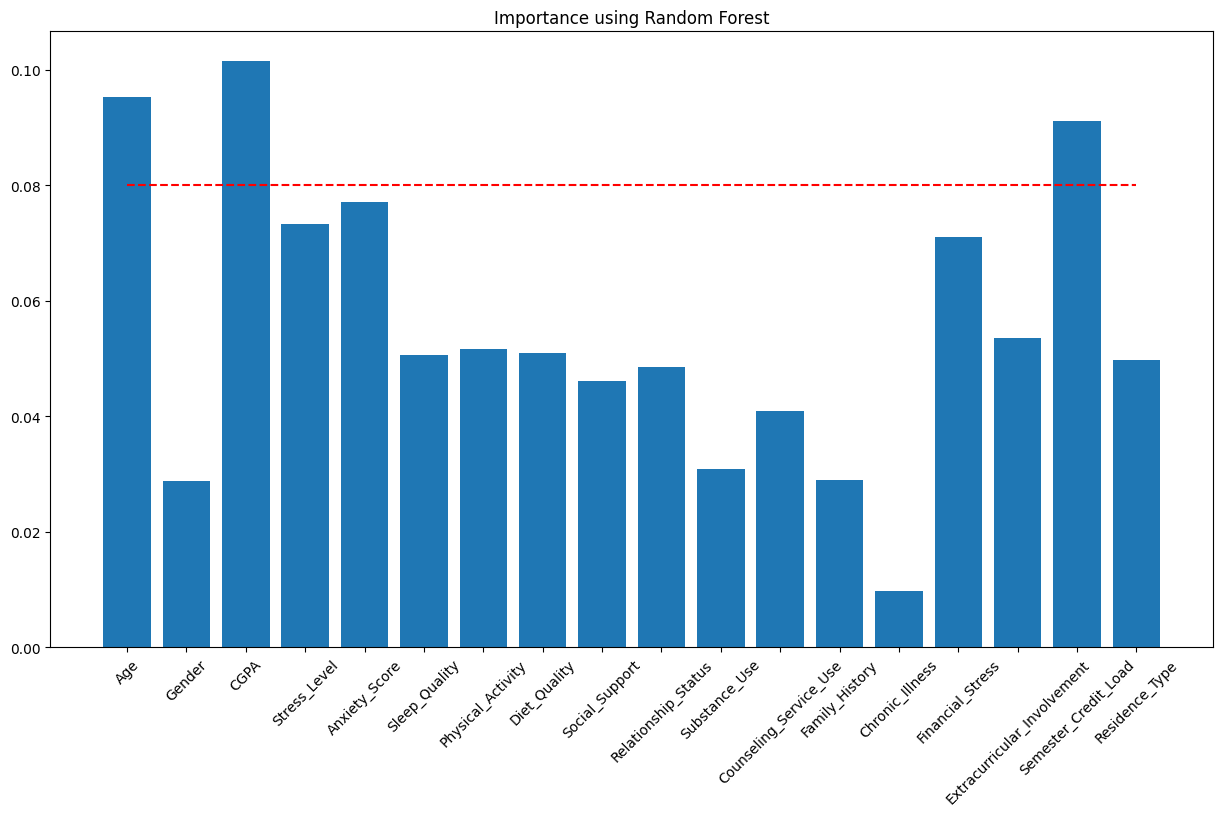

=============== compsci ===============

Accuracy: 0.2671009771986971 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.105167
16         Semester_Credit_Load    0.093458
0                           Age    0.089696
4                 Anxiety_Score    0.076797
14             Financial_Stress    0.074455
3                  Stress_Level    0.073759
15  Extracurricular_Involvement    0.052055
6             Physical_Activity    0.051101
17               Residence_Type    0.050285
8                Social_Support    0.050090
9           Relationship_Status    0.046999
7                  Diet_Quality    0.046364
5                 Sleep_Quality    0.044990
11       Counseling_Service_Use    0.044444
12               Family_History    0.029931
10                Substance_Use    0.029896
1                        Gender    0.029511
13              Chronic_Illness    0.011003


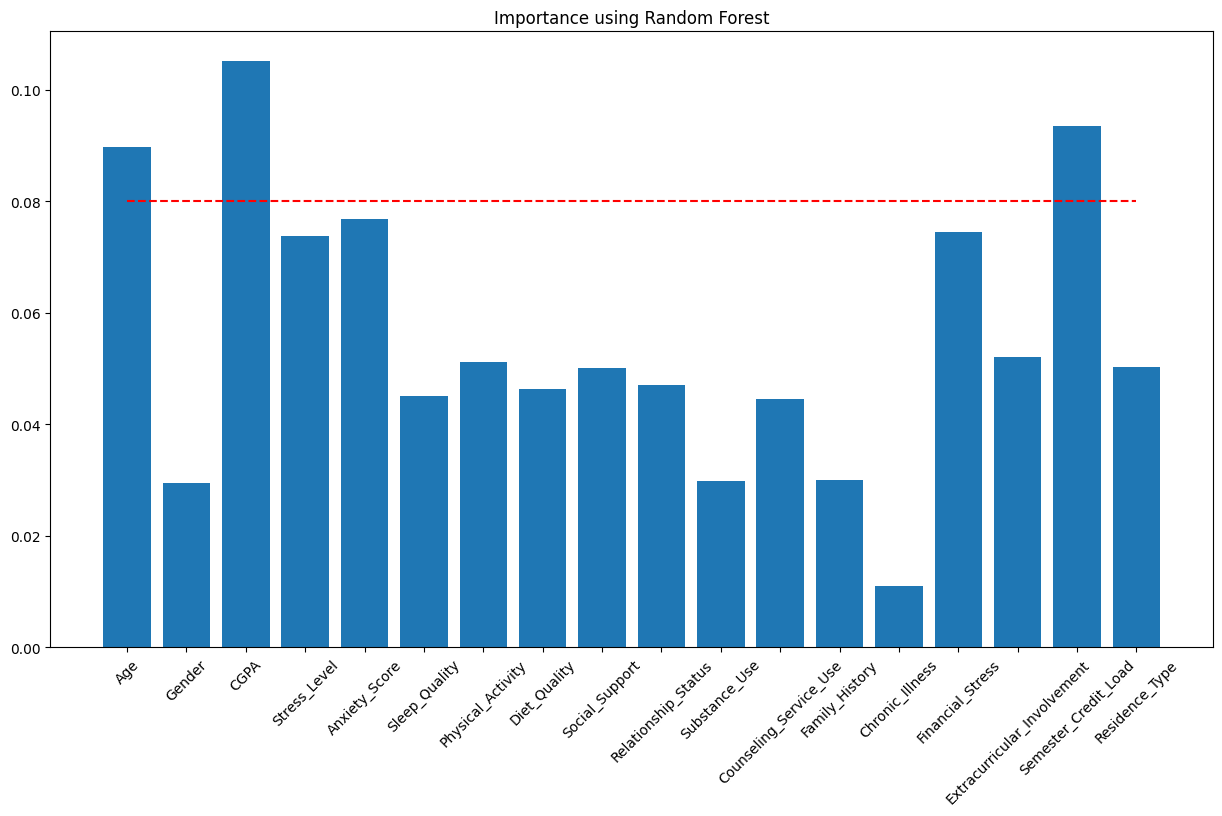

=============== engineering ===============

Accuracy: 0.16510903426791276 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.130702
0                           Age    0.104739
16         Semester_Credit_Load    0.101229
4                 Anxiety_Score    0.076506
14             Financial_Stress    0.074852
3                  Stress_Level    0.072885
6             Physical_Activity    0.047475
15  Extracurricular_Involvement    0.046994
17               Residence_Type    0.045955
9           Relationship_Status    0.045341
7                  Diet_Quality    0.045254
8                Social_Support    0.044298
5                 Sleep_Quality    0.042523
11       Counseling_Service_Use    0.039022
1                        Gender    0.027813
12               Family_History    0.024828
10                Substance_Use    0.021116
13              Chronic_Illness    0.008469


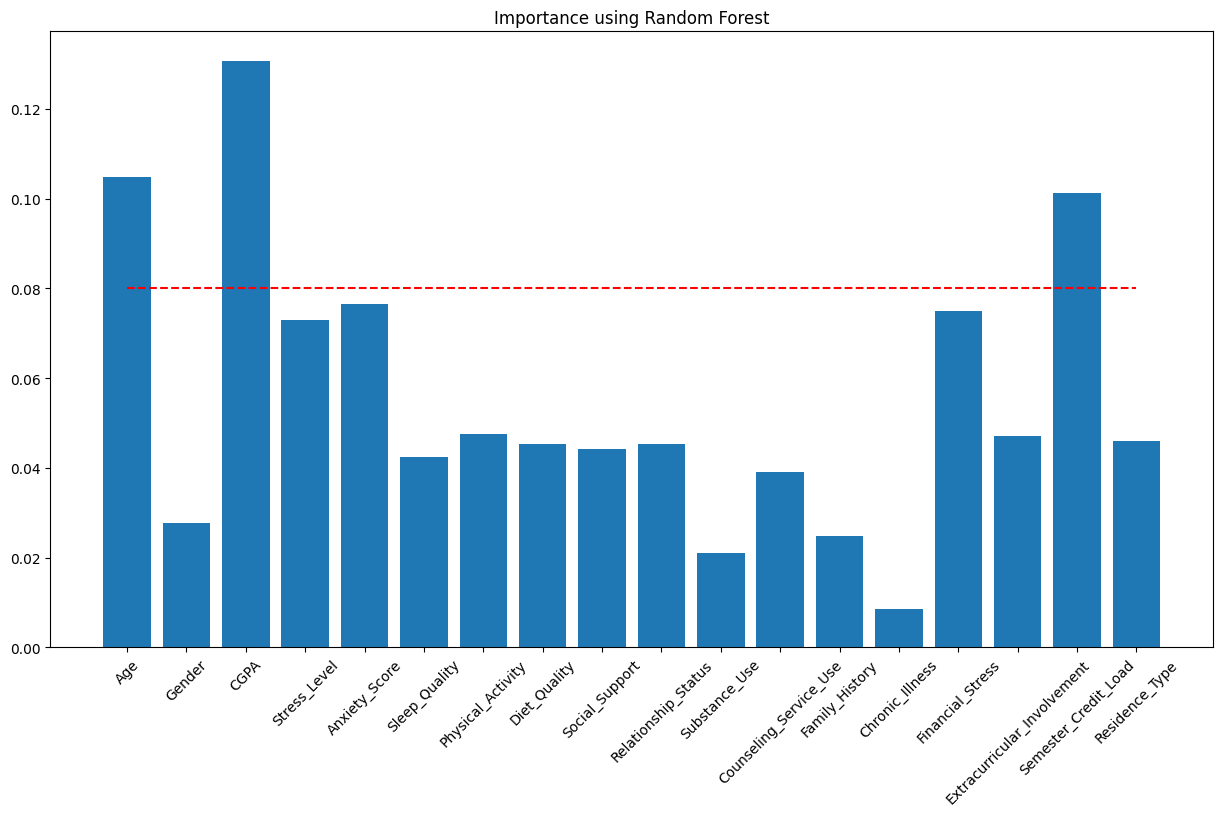

=============== law ===============

Accuracy: 0.2457831325301205 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.129327
0                           Age    0.103763
16         Semester_Credit_Load    0.098045
4                 Anxiety_Score    0.076212
3                  Stress_Level    0.074179
14             Financial_Stress    0.071807
15  Extracurricular_Involvement    0.048344
17               Residence_Type    0.046538
6             Physical_Activity    0.044762
9           Relationship_Status    0.044052
7                  Diet_Quality    0.042653
8                Social_Support    0.042158
5                 Sleep_Quality    0.042077
11       Counseling_Service_Use    0.040333
12               Family_History    0.030398
1                        Gender    0.028565
10                Substance_Use    0.025804
13              Chronic_Illness    0.010981


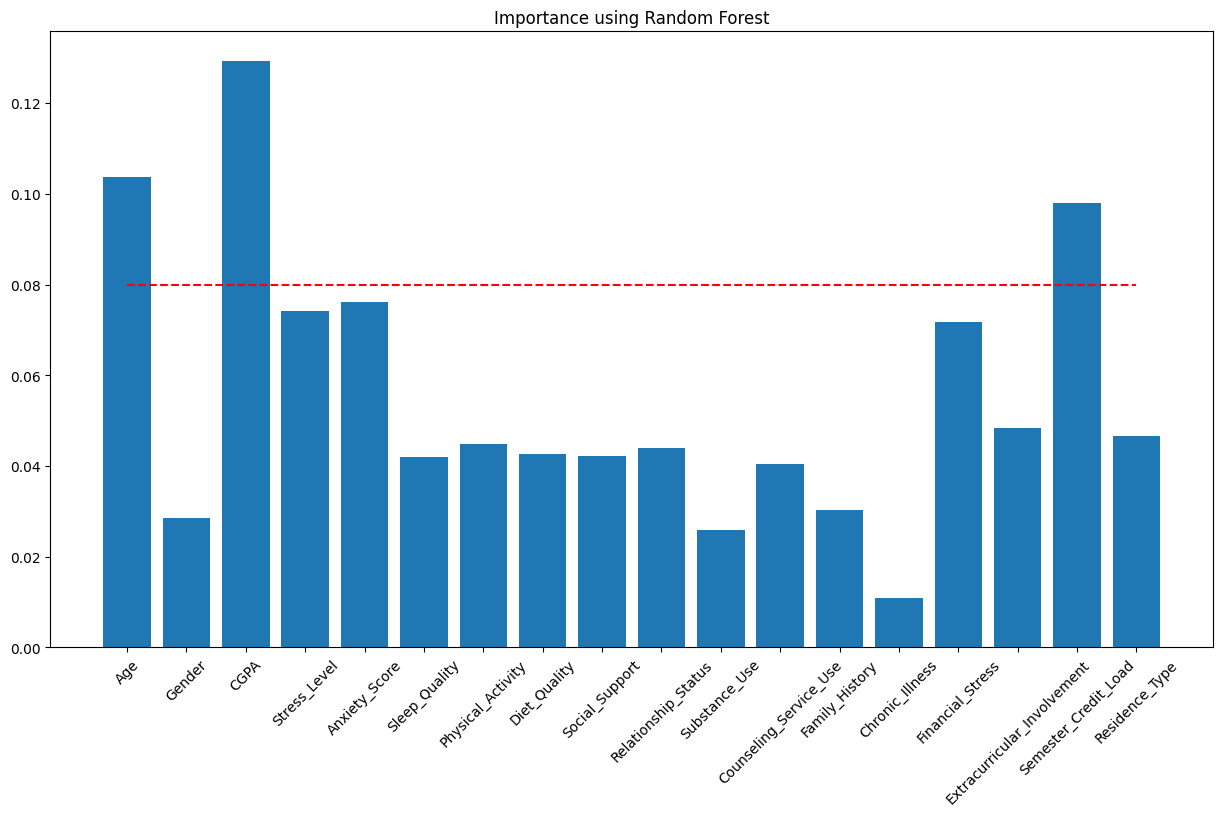

=============== medical ===============

Accuracy: 0.21939586645468998 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.138002
16         Semester_Credit_Load    0.103165
0                           Age    0.101756
14             Financial_Stress    0.073128
4                 Anxiety_Score    0.071149
3                  Stress_Level    0.067791
15  Extracurricular_Involvement    0.048994
17               Residence_Type    0.048096
6             Physical_Activity    0.045977
8                Social_Support    0.045805
9           Relationship_Status    0.044135
11       Counseling_Service_Use    0.040928
7                  Diet_Quality    0.040097
5                 Sleep_Quality    0.039643
1                        Gender    0.031361
12               Family_History    0.027987
10                Substance_Use    0.024579
13              Chronic_Illness    0.007407


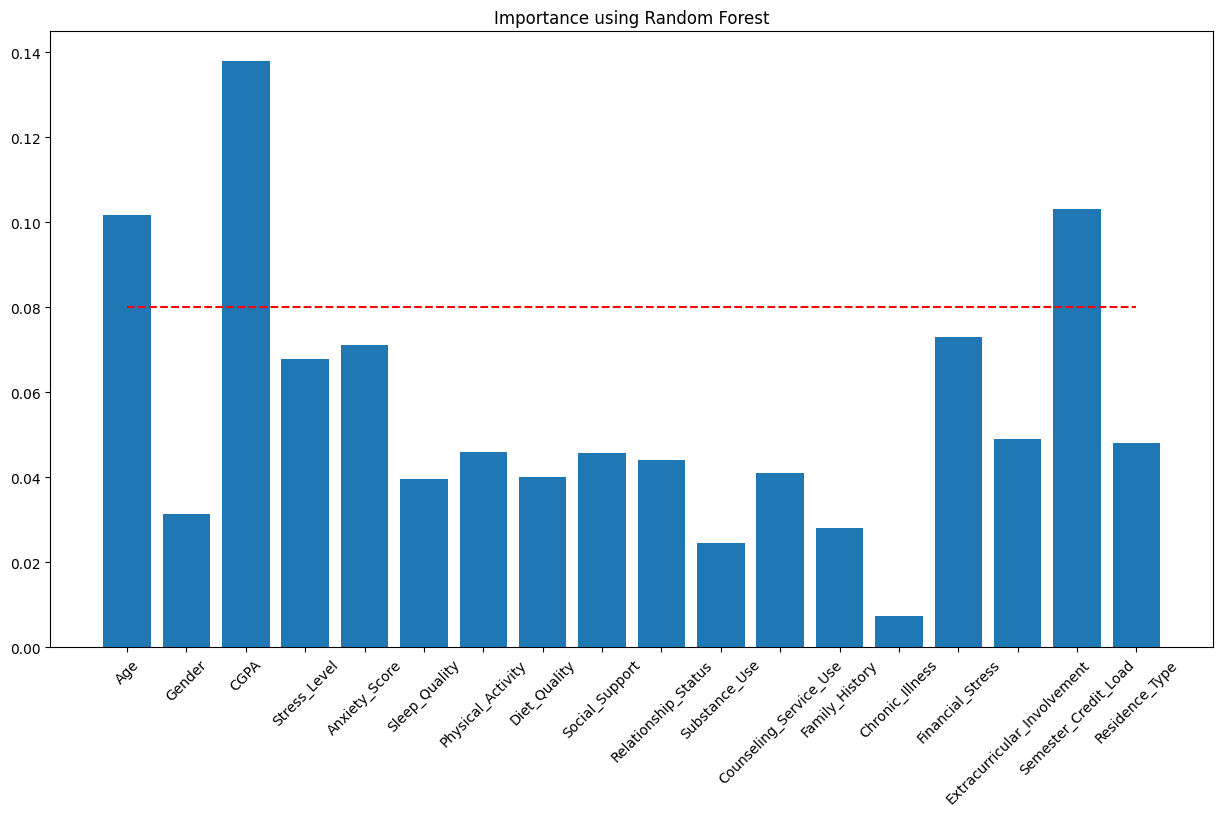

=============== others ===============

Accuracy: 0.25116279069767444 

Feature Importance:
                        Feature  Importance
2                          CGPA    0.099895
16         Semester_Credit_Load    0.093427
0                           Age    0.092846
14             Financial_Stress    0.076409
4                 Anxiety_Score    0.076207
3                  Stress_Level    0.075734
17               Residence_Type    0.052981
15  Extracurricular_Involvement    0.052319
6             Physical_Activity    0.050003
8                Social_Support    0.049373
7                  Diet_Quality    0.047353
5                 Sleep_Quality    0.044655
11       Counseling_Service_Use    0.043818
9           Relationship_Status    0.042944
1                        Gender    0.031175
12               Family_History    0.030517
10                Substance_Use    0.025369
13              Chronic_Illness    0.014974


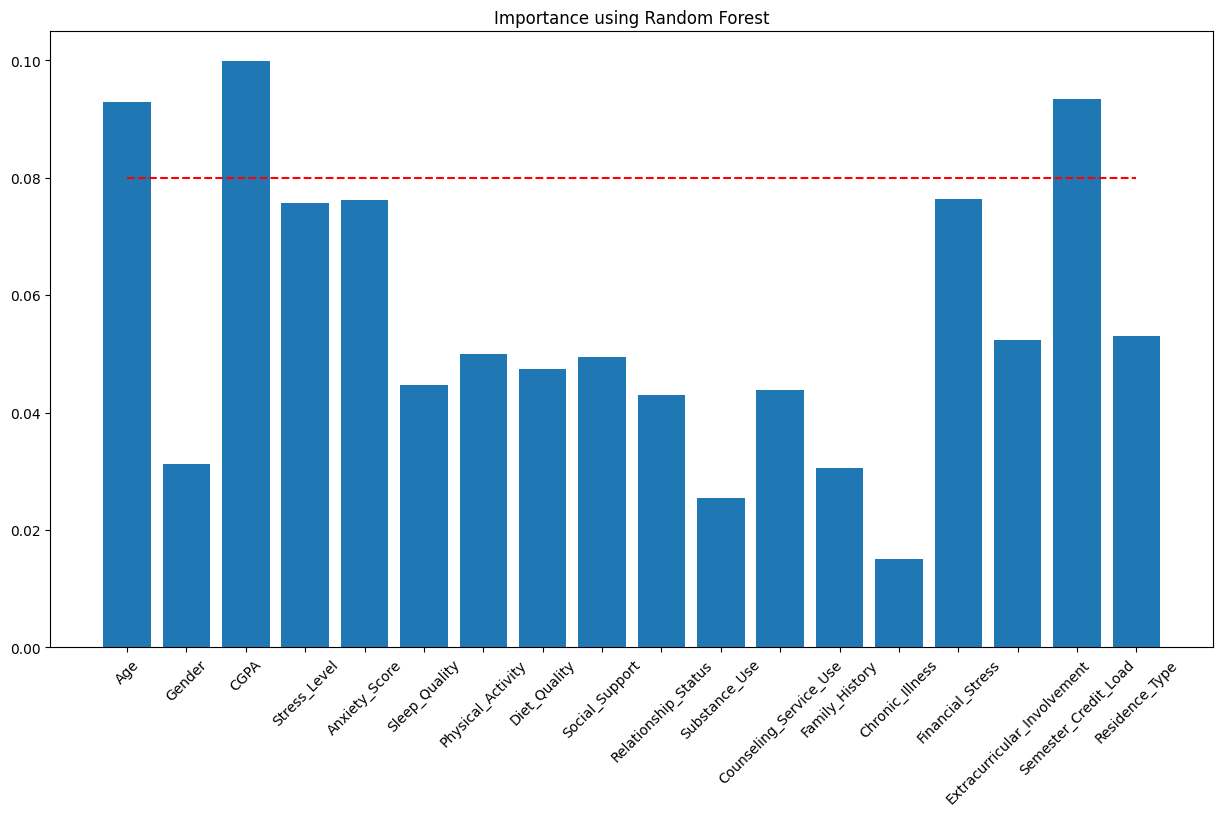

In [104]:
for course in courses:
    print("="*15, course, "="*15)
    data = pd.read_csv(f'../Data/clean_df_{course}.csv')
    data.drop(['Course'], axis=1, inplace=True)

    X = data.drop(['Depression_Score'], axis=1)
    y = data['Depression_Score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train = minMaxScaler.fit_transform(X_train)
    X_test = minMaxScaler.transform(X_test)

    get_importance(X_train, X_test, y_train, y_test, importance_verbose=True, params_verbose=False)

top 6 features for all datasets: ['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']

# Pair plots

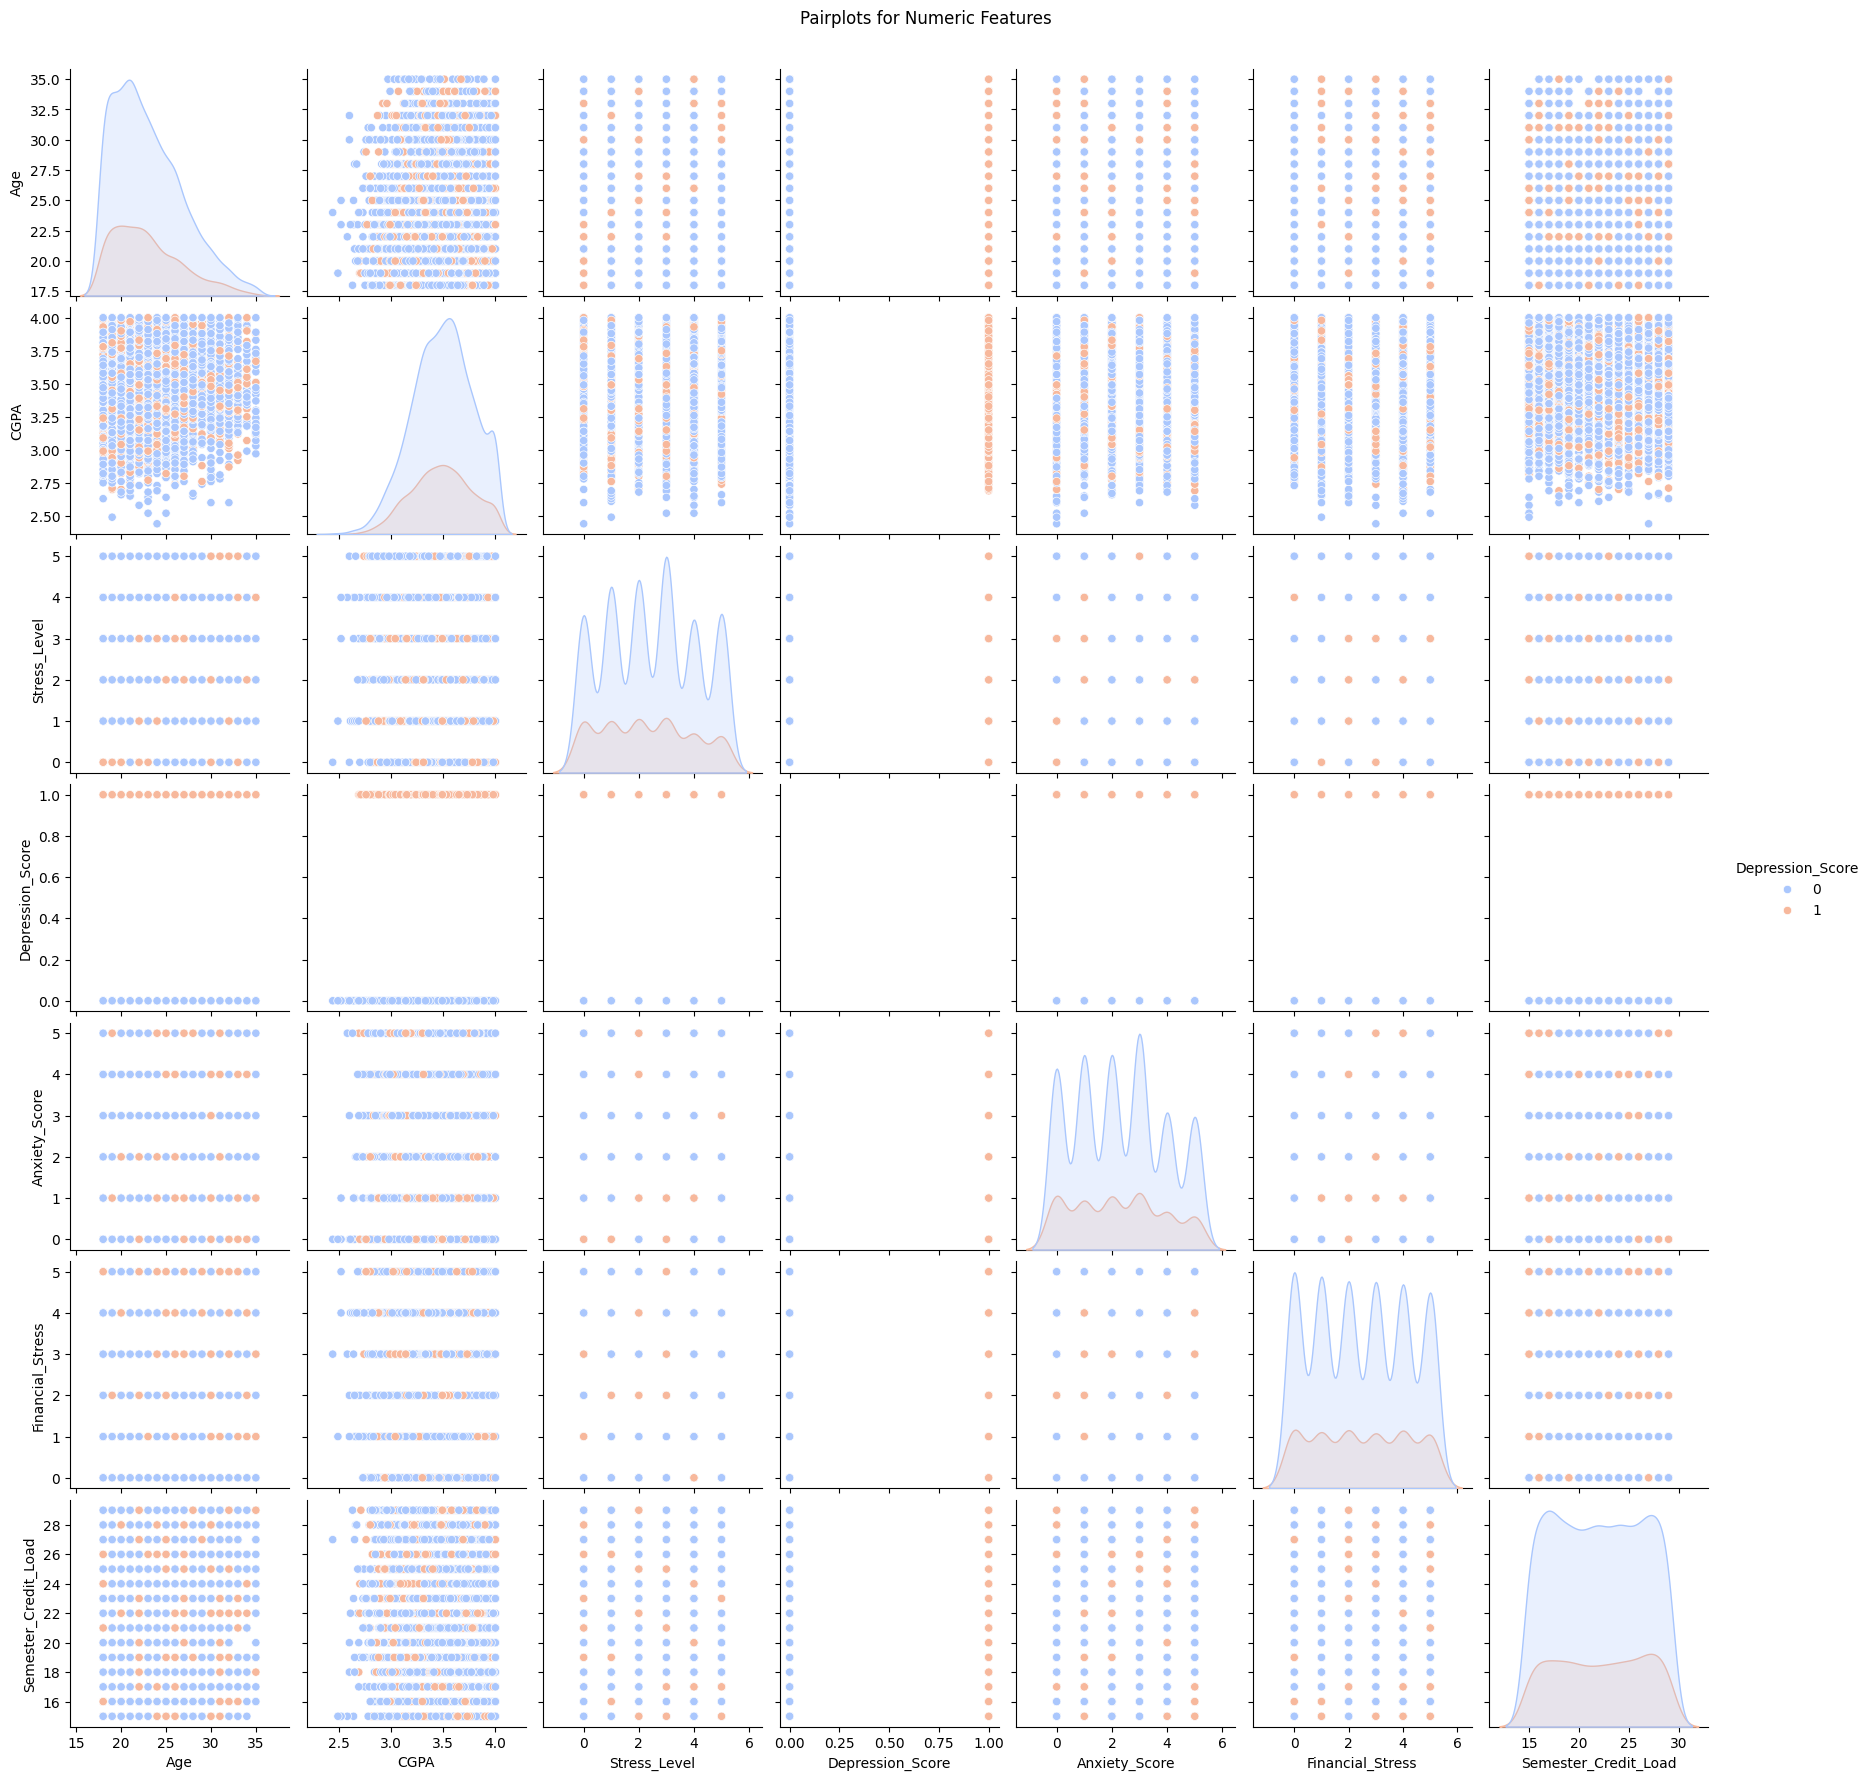

In [114]:
columns_to_include = ['Age', 'CGPA', 'Stress_Level', 'Depression_Score', 'Anxiety_Score', 'Financial_Stress', 'Semester_Credit_Load']

sns.pairplot(df, 
             vars=columns_to_include, 
             hue='Depression_Score', 
             diag_kind='kde', 
             palette='coolwarm')

plt.suptitle("Pairplots for Numeric Features", y=1.02)
plt.show()

# Model Training

In [ ]:
optimal_params = {
    'business': {
        
    },
    'compsci': {},
    'engineering': {},
    'law': {},
    'medical': {},
    'others': {}
}

In [ ]:
features = ['Age', 'CGPA', 'Semester_Credit_Load']
depression_threshold = 4

In [93]:
FIT_THRESHOLD = 0.05  # Set a 5% threshold for acceptable difference

In [94]:
def test_model_fit(X_train, y_train, X_test, y_test):
    # Define a list of models
    models = {
        'Logistic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'SVC': SVC()
        # 'Neural Network': KerasClassifier()
    }

    # Dictionary to store performance metrics
    train_scores = {}
    test_scores = {}

    # Train and evaluate each model
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Get predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute accuracy for both training and testing
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Store the accuracy
        train_scores[name] = train_acc
        test_scores[name] = test_acc
        
        # Print the performance for each model
        print(f"{name}:")
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Testing Accuracy: {test_acc:.4f}")
        
        # Check if overfitting or underfitting
        if abs(train_acc - test_acc) <= FIT_THRESHOLD:
            print(f"  Model is performing well on both training and test data.\n")
        elif train_acc - test_acc > FIT_THRESHOLD:
            print(f"  Model is likely overfitting.")
        elif test_acc - train_acc > FIT_THRESHOLD:
            print(f"  Model is likely underfitting.")

        print("\nClassification report on the test set:")
        print(classification_report(y_test, y_test_pred))


    # Visualize the results with a bar plot
    model_names = list(models.keys())
    train_values = list(train_scores.values())
    test_values = list(test_scores.values())

    x = np.arange(len(model_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, train_values, width, label='Train')
    rects2 = ax.bar(x + width/2, test_values, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance: Training vs Testing')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    # Show the plot
    plt.show()


=============== business ===============
Logistic Regression:
  Training Accuracy: 0.8960
  Testing Accuracy: 0.8930
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       192
           1       0.00      0.00      0.00        23

    accuracy                           0.89       215
   macro avg       0.45      0.50      0.47       215
weighted avg       0.80      0.89      0.84       215

KNN:
  Training Accuracy: 0.9140
  Testing Accuracy: 0.8837
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       192
           1       0.00      0.00      0.00        23

    accuracy                           0.88       215
   macro avg       0.45      0.49      0.47       215
weighted avg       0.80 

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

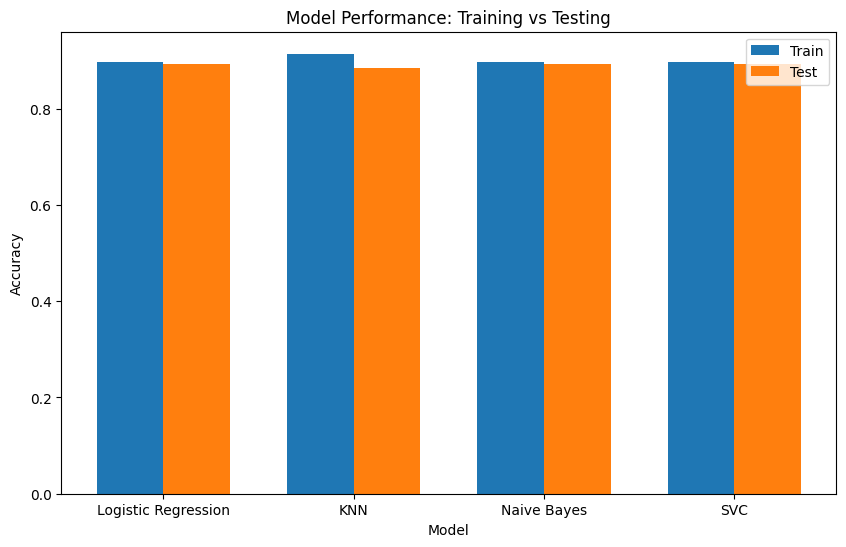



=============== compsci ===============
Logistic Regression:
  Training Accuracy: 0.7497
  Testing Accuracy: 0.7231
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       222
           1       0.00      0.00      0.00        85

    accuracy                           0.72       307
   macro avg       0.36      0.50      0.42       307
weighted avg       0.52      0.72      0.61       307

KNN:
  Training Accuracy: 0.7818
  Testing Accuracy: 0.6678
  Model is likely overfitting.

Classification report on the test set:
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       222
           1       0.16      0.05      0.07        85

    accuracy                           0.67       307
   macro avg       0.44      0.48      0.44       307
weighted avg       0.56      0.67      0.60       30

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

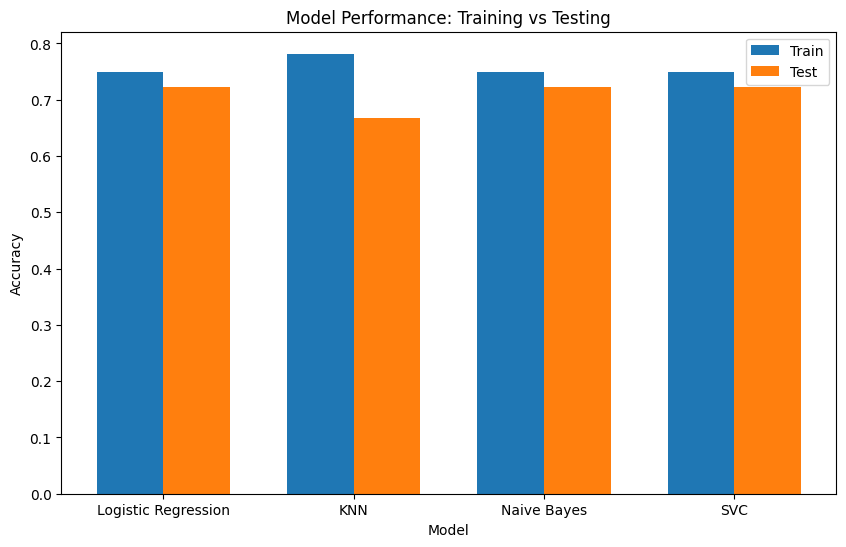



=============== engineering ===============
Logistic Regression:
  Training Accuracy: 0.9196
  Testing Accuracy: 0.8785
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       282
           1       0.00      0.00      0.00        39

    accuracy                           0.88       321
   macro avg       0.44      0.50      0.47       321
weighted avg       0.77      0.88      0.82       321

KNN:
  Training Accuracy: 0.9196
  Testing Accuracy: 0.8785
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       282
           1       0.00      0.00      0.00        39

    accuracy                           0.88       321
   macro avg       0.44      0.50      0.47       321
weighted avg       

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

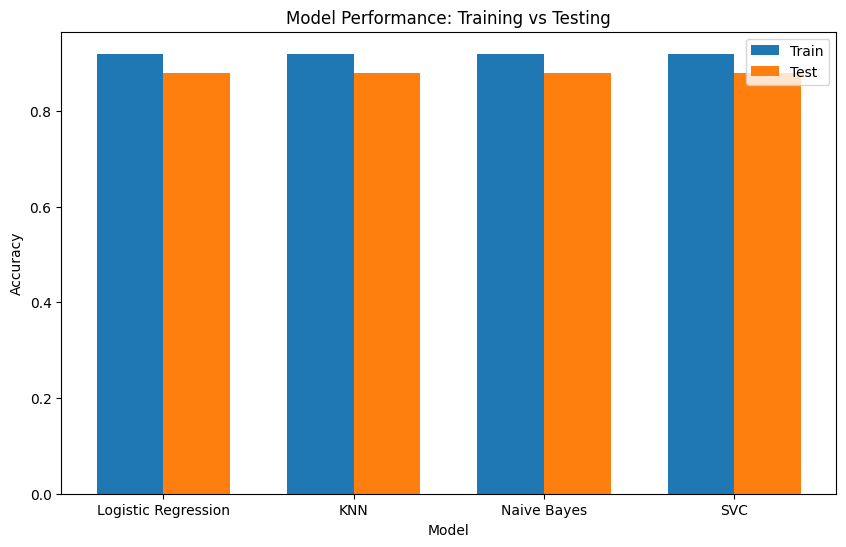



=============== law ===============
Logistic Regression:
  Training Accuracy: 0.9017
  Testing Accuracy: 0.9084
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       377
           1       0.00      0.00      0.00        38

    accuracy                           0.91       415
   macro avg       0.45      0.50      0.48       415
weighted avg       0.83      0.91      0.86       415

KNN:
  Training Accuracy: 0.9017
  Testing Accuracy: 0.9012
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       377
           1       0.00      0.00      0.00        38

    accuracy                           0.90       415
   macro avg       0.45      0.50      0.47       415
weighted avg       0.82    

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

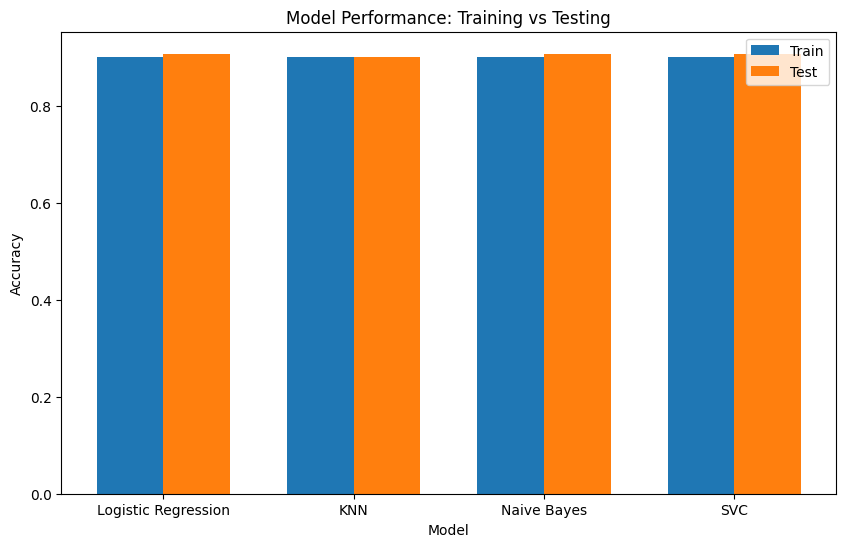



=============== medical ===============
Logistic Regression:
  Training Accuracy: 0.9127
  Testing Accuracy: 0.8903
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       560
           1       0.00      0.00      0.00        69

    accuracy                           0.89       629
   macro avg       0.45      0.50      0.47       629
weighted avg       0.79      0.89      0.84       629

KNN:
  Training Accuracy: 0.9134
  Testing Accuracy: 0.8919
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       560
           1       0.67      0.03      0.06        69

    accuracy                           0.89       629
   macro avg       0.78      0.51      0.50       629
weighted avg       0.87

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

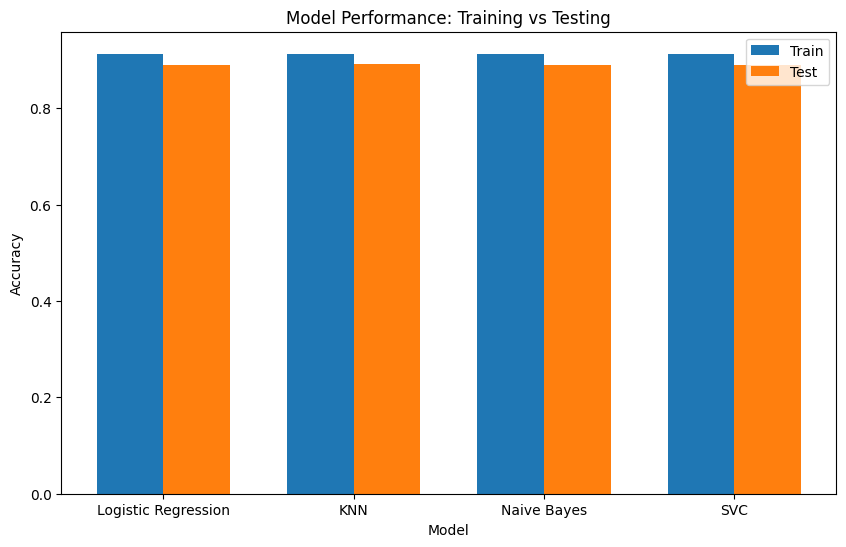



=============== others ===============
Logistic Regression:
  Training Accuracy: 0.8918
  Testing Accuracy: 0.9116
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       196
           1       0.00      0.00      0.00        19

    accuracy                           0.91       215
   macro avg       0.46      0.50      0.48       215
weighted avg       0.83      0.91      0.87       215

KNN:
  Training Accuracy: 0.8918
  Testing Accuracy: 0.8977
  Model is performing well on both training and test data.


Classification report on the test set:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       196
           1       0.00      0.00      0.00        19

    accuracy                           0.90       215
   macro avg       0.46      0.49      0.47       215
weighted avg       0.83 

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\repos\student-mental-health-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

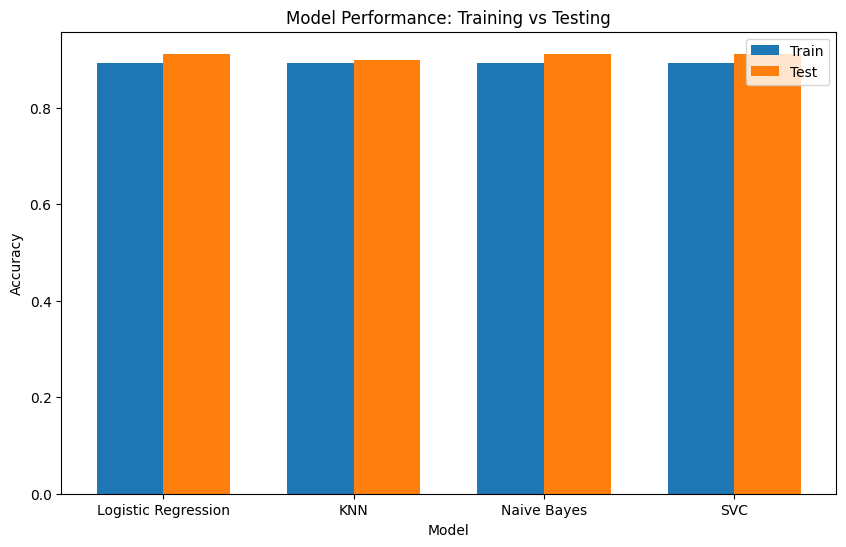

In [95]:


for major in majors:
    print("="*15, major, "="*15)
    data = pd.read_csv(f'../Data/clean_df_{major}.csv')
    data.drop(['Course'], axis=1, inplace=True)
    data['Depression_Score'] = data['Depression_Score'].apply(lambda x: 1 if x > depression_threshold else 0)

    X = data[features]
    y = data['Depression_Score']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # compute_best_random_state(X, y, data)
    test_model_fit(X_train, y_train, X_test, y_test)
    print("\n")
